In [2]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import numpy as np
import pandas as pd
import keras
import krakenex
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

col_list = ["Open_Slope","Close_Slope","Volume_Slope"]
open_dataset = pd.read_csv('./data/gemini_ETHUSD_1hr.csv', usecols=col_list, sep=',')
open_dataset = open_dataset[1:]

api = krakenex.API()
api.load_key('kraken.key')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
epochs = 20
batch_size = 12

In [4]:
n_train_rows = int(open_dataset.shape[0]*.7)-1
n_valid_rows = int(open_dataset.shape[0]*.9)-1

train = open_dataset[:n_train_rows]
test = open_dataset[n_train_rows:n_valid_rows]
valid = open_dataset[n_valid_rows:]
print(train.shape)
print(test.shape)
print(valid.shape)
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = np.flipud(np.array(train))
test_set_scaled = np.flipud(np.array(test))
valid_set_scaled = np.flipud(np.array(valid))

(32327, 3)
(9237, 3)
(4620, 3)


In [4]:
n_train_rows = int(open_dataset.shape[0])-1
train = open_dataset[:n_train_rows]
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = np.flipud(np.array(train))
print(train.shape)

(46183, 3)


In [18]:
# Prepare the training data
combine = 10

x_train = []
y_train = []
for i in range(combine, training_set_scaled.shape[0]-1):
    x_train.append(training_set_scaled[i-combine:i, :])
    y_train.append(training_set_scaled[i+1, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

# Prepare the test data
x_test = []
y_test = []

for i in range(combine, test_set_scaled.shape[0]-1):
    x_test.append(test_set_scaled[i-combine:i, :])
    y_test.append(test_set_scaled[i+1, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

# Prepare the test data
x_valid = []
y_valid = []

for i in range(combine, valid_set_scaled.shape[0]-1):
    x_valid.append(valid_set_scaled[i-combine:i, :])
    y_valid.append(valid_set_scaled[i+1, :])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)
print(x_valid.shape)
print(y_valid.shape)

(32316, 10, 3)
(32316, 3)
(9226, 10, 3)
(9226, 3)
(4609, 10, 3)
(4609, 3)


In [19]:
#Training data for many to many model
pred_step = 1
x_train_m2m = x_train[:,:combine,:]
y_train_m2m = x_train[:,-pred_step:,:]

x_test_m2m = x_test[:,:combine,:]
y_test_m2m = x_test[:,-pred_step:,:]

x_valid_m2m = x_valid[:,:combine,:]
y_valid_m2m = x_valid[:,-pred_step:,:]
# for step_ahead in range(1,pred_step+1):
#     y_train_m2m[:,:,step_ahead-1] = x_train[:,step_ahead:step_ahead+combine-pred_step,0]

# x_test_m2m = x_test[:,:combine-pred_step,:]
# y_test_m2m = np.empty((y_test.shape[0], combine-pred_step, pred_step))
# for step_ahead in range(1,pred_step+1):
#     y_test_m2m[:,:,step_ahead-1] = x_test[:,step_ahead:step_ahead+combine-pred_step,0]
    
# x_valid_m2m = x_valid[:,:combine-pred_step,:]
# y_valid_m2m = np.empty((y_valid.shape[0], combine-pred_step, pred_step))
# for step_ahead in range(1,pred_step+1):
#     y_valid_m2m[:,:,step_ahead-1] = x_valid[:,step_ahead:step_ahead+combine-pred_step,0]    

In [52]:
print(x_train_m2m.shape)
print(y_train_m2m.shape)

(32315, 10, 3)
(32315, 1, 3)


In [7]:
shape = 3

In [20]:
model5 = Sequential()
model5.add(keras.layers.InputLayer(input_shape = [None,shape]))
for rate in (1,2,4,8) *2:
    model5.add(keras.layers.Conv1D(20,kernel_size=3, padding = "causal", activation = "relu", dilation_rate = rate))
model5.add(keras.layers.Conv1D(shape, kernel_size = 1))
model5.compile(loss="mse", optimizer="adam")

In [21]:
model5.fit(x_train_m2m, y_train_m2m, batch_size = batch_size, epochs = epochs, validation_data=(x_valid_m2m,y_valid_m2m))

Epoch 1/20
2693/2693 [==============================] - 15s 3ms/step - loss: 1435266.3255 - val_loss: 133839.4531
Epoch 2/20
2693/2693 [==============================] - 7s 2ms/step - loss: 1355710.8180 - val_loss: 131870.0000
Epoch 3/20
2693/2693 [==============================] - 7s 2ms/step - loss: 1374390.6491 - val_loss: 127620.6797
Epoch 4/20
2693/2693 [==============================] - 7s 2ms/step - loss: 1383288.9613 - val_loss: 127340.7578
Epoch 5/20
2693/2693 [==============================] - 7s 2ms/step - loss: 1362354.5756 - val_loss: 125483.8125
Epoch 6/20
2693/2693 [==============================] - 7s 2ms/step - loss: 1383475.8138 - val_loss: 123902.6797
Epoch 7/20
2693/2693 [==============================] - 7s 3ms/step - loss: 1505119.4279 - val_loss: 124304.0781
Epoch 8/20
2693/2693 [==============================] - 7s 3ms/step - loss: 1465314.2128 - val_loss: 123870.7812
Epoch 9/20
2693/2693 [==============================] - 7s 3ms/step - loss: 1633330.1501 - val_

In [55]:
model5.save("ETH_model5_wavenet_"+ str(batch_size) +"bat_"+ str(epochs) +"epochs_kernal_3_NotScaled_Slope_v2.h5")

In [44]:
model6 = Sequential()
model6.add(keras.layers.InputLayer(input_shape = [None,shape]))
model6.add(keras.layers.Conv1D(20,kernel_size=2, padding = "causal", activation = "relu"))
model6.add(keras.layers.GRU(20, return_sequences=True))
model6.add(keras.layers.GRU(20, return_sequences=True))
model6.add(Dense(shape))

model6.compile(loss="mse", optimizer="adam")

In [45]:
model6.fit(x_train_m2m, y_train_m2m, batch_size = batch_size, epochs = epochs, validation_data=(x_valid_m2m,y_valid_m2m))

Epoch 1/20
3848/3848 [==============================] - 30s 7ms/step - loss: 19265850.5383 - val_loss: 141588.1094
Epoch 2/20
3848/3848 [==============================] - 25s 6ms/step - loss: 16459411.0055 - val_loss: 141588.3594
Epoch 3/20
3848/3848 [==============================] - 25s 7ms/step - loss: 14232418.2240 - val_loss: 141588.1250
Epoch 4/20
3848/3848 [==============================] - 25s 6ms/step - loss: 17032730.7538 - val_loss: 141587.5781
Epoch 5/20
3848/3848 [==============================] - 25s 6ms/step - loss: 17276225.7513 - val_loss: 141586.9688
Epoch 6/20
3848/3848 [==============================] - 25s 7ms/step - loss: 14398124.0427 - val_loss: 141586.9375
Epoch 7/20
3848/3848 [==============================] - 25s 6ms/step - loss: 16349832.7032 - val_loss: 141586.4375
Epoch 8/20
3848/3848 [==============================] - 25s 7ms/step - loss: 13336814.6754 - val_loss: 141585.6562
Epoch 9/20
3848/3848 [==============================] - 25s 7ms/step - loss: 970

In [61]:
model6.save("model6_GRU_"+ str(batch_size) +"bat_"+ str(epochs) +"epochs_m2m_NotScaled_Slope.h5")

In [46]:
y_hat6 = model6.predict(x_test_m2m)

In [22]:
y_hat5 = model5.predict(x_test_m2m)

In [23]:
y_hat5.shape

(9226, 10, 3)

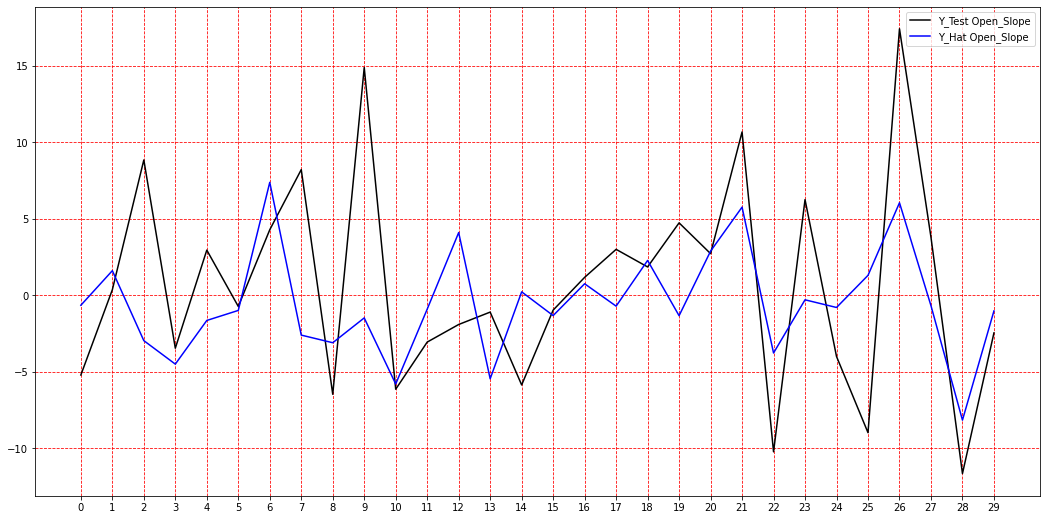

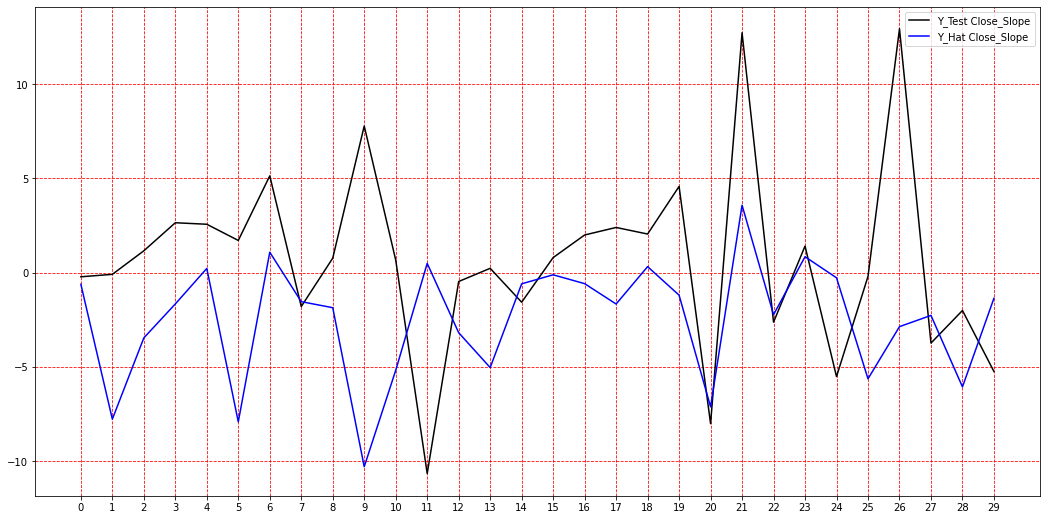

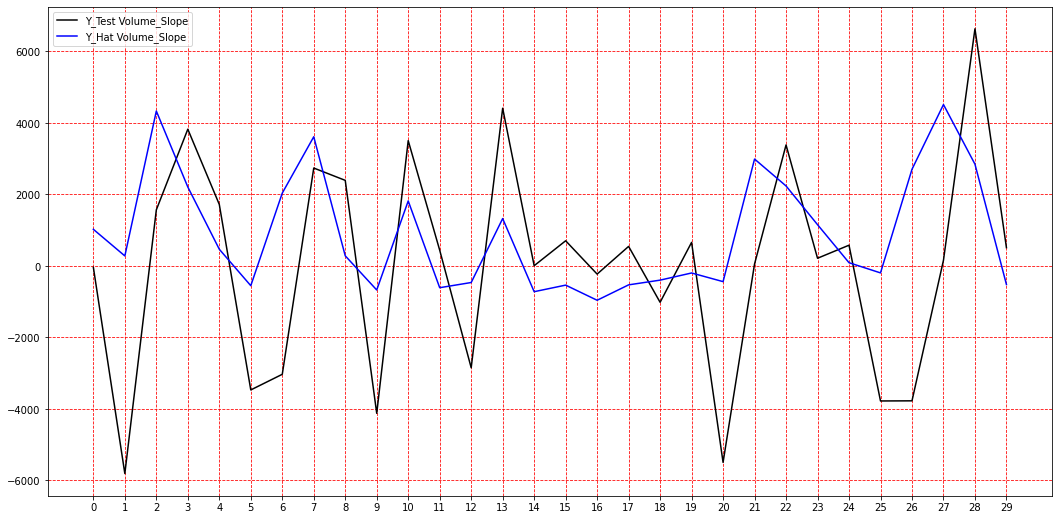

In [28]:
num_of_instance = y_hat5.shape[0]
target_index = num_of_instance -1

interval = 30

predict_index = target_index - interval

plt.figure(figsize = (18,9))
plt.plot(y_test_m2m[predict_index:target_index,-1,0], color = 'black', label = "Y_Test Open_Slope")
plt.plot(y_hat5[predict_index:target_index,-1,0], color = 'blue', label = "Y_Hat Open_Slope")
plt.xticks(np.arange(0, interval, step=1))  # Set label locations.
plt.grid(color='r', linestyle='--')
plt.legend()

plt.figure(figsize = (18,9))
plt.plot(y_test_m2m[predict_index:target_index,-1,1], color = 'black', label = "Y_Test Close_Slope")
plt.plot(y_hat5[predict_index:target_index,-1,1], color = 'blue', label = "Y_Hat Close_Slope")
plt.xticks(np.arange(0, interval, step=1))  # Set label locations.
plt.grid(color='r', linestyle='--')
plt.legend()



plt.figure(figsize = (18,9))
plt.plot(y_test_m2m[predict_index:target_index,0,2], color = 'black', label = "Y_Test Volume_Slope")
plt.plot(y_hat5[predict_index:target_index,-2,2], color = 'blue', label = "Y_Hat Volume_Slope")
plt.xticks(np.arange(0, interval, step=1))  # Set label locations.
plt.grid(color='r', linestyle='--')
plt.legend()


In [147]:
profit = 0
count  = 0
for i in range(2,y_hat5.shape[0]-1):
    #positive slope
    if y_hat5[i,-1,0]>0:
        #concave up
        if y_hat5[i,-1,0] > y_test_m2m[i-1,-1,0]:
            #volume was down prev.
            if y_test_m2m[i-2,-1,2] > 0 and y_test_m2m[i-1,-1,2] < 0:
                profit += (float(x_test_m2m[i,-1,1]) - float(x_test_m2m[i,-1,0]))
                count += 1
        
print(profit)
print(count)

-189.79000000000002
872


In [149]:
# Trading Signal tester model 5
for kernal in range (2,20):
    batch_size = 12
    model5 = Sequential()
    model5.add(keras.layers.InputLayer(input_shape = [None,shape]))
    for rate in (1,2,4,8) *2:
        model5.add(keras.layers.Conv1D(20,kernel_size=kernal, padding = "causal", activation = "relu", dilation_rate = rate))
    model5.add(keras.layers.Conv1D(shape, kernel_size = 1))
    model5.compile(loss="mse", optimizer="adam")
    
    model5.fit(x_train_m2m, y_train_m2m, batch_size = batch_size, epochs = epochs, validation_data=(x_valid_m2m,y_valid_m2m))
    y_hat5 = model5.predict(x_test_m2m)
    profit = 0
    count  = 0
    for i in range(2,y_hat5.shape[0]-1):
        #positive open slope
        if y_hat5[i,-1,0]>0:        
            #concave up
            if y_hat5[i,-1,0] > x_test_m2m[i,-1,0]:
                if y_hat5[i,-1,1] > x_test_m2m[i,-1,1]:
                #positive close slope
                    if y_hat5[i,-1,1] > 0:
                    #close slope higher than open slope
                        if y_hat6[i,-1,1] > y_hat6[i,-1,0]:
                            if y_test_m2m[i-1,-1,1] > 0:
                                profit += 1
                                count += 1
                            elif y_test_m2m[i-1,-1,1] < 0:
                                    profit -= 1
                                    count +=1
    
    print("model 5 alone")
    print(profit)
    print(count)
    print("kernal size:" + str(kernal))
    print("")

Epoch 1/20
2693/2693 [==============================] - 8s 2ms/step - loss: 1504920.6489 - val_loss: 140722.4531
Epoch 2/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1539112.8550 - val_loss: 139458.1875
Epoch 3/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1542564.4804 - val_loss: 139479.4375
Epoch 4/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1442011.2889 - val_loss: 139316.5625
Epoch 5/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1551273.9271 - val_loss: 139037.2344
Epoch 6/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1335750.1293 - val_loss: 139200.7500
Epoch 7/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1555617.9472 - val_loss: 138707.4844
Epoch 8/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1523616.3089 - val_loss: 138918.4375
Epoch 9/20
2693/2693 [==============================] - 6s 2ms/step - loss: 1448538.4431 - val_l

KeyboardInterrupt: 

In [141]:
# Trading Signal tester model 6
for batch_size in range (10,50,2):

    model6.fit(x_train_m2m, y_train_m2m, batch_size = batch_size, epochs = epochs, validation_data=(x_valid_m2m,y_valid_m2m))
    y_hat6 = model6.predict(x_test_m2m)
    profit = 0
    count  = 0
    for i in range(2,y_hat6.shape[0]-1):
        #positive open slope
        if y_hat6[i,-1,0]>0:        
            #concave up
            if y_hat6[i,-1,0] > x_test_m2m[i,-1,0]:
                if y_hat6[i,-1,1] > x_test_m2m[i,-1,1]:
                #positive close slope
                    if y_hat6[i,-1,1] > 0:
                        if y_test_m2m[i,-1,1] > 0:
                            profit += 1
                            count += 1
                        elif y_test_m2m[i,-1,1] < 0:
                                profit -= 1
                                count +=1
    print("model 6 alone")
    print(profit)
    print(count)
    print("batch size:" + str(batch_size))
    print("")

Epoch 1/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1492161.3750 - val_loss: 141771.0625
Epoch 2/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1491645.5000 - val_loss: 141775.8125
Epoch 3/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1491431.1250 - val_loss: 141622.2656
Epoch 4/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1491462.3750 - val_loss: 141651.5156
Epoch 5/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1491036.3750 - val_loss: 141576.3906
Epoch 6/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1491025.8750 - val_loss: 141585.7344
Epoch 7/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1491075.8750 - val_loss: 141587.2969
Epoch 8/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1490747.1250 - val_loss: 141583.0312
Epoch 9/20
3232/3232 [==============================] - 23s 7ms/step - loss: 1490749.750

1347/1347 [==============================] - 10s 7ms/step - loss: 1483283.1250 - val_loss: 144520.5625
Epoch 2/20
1347/1347 [==============================] - 10s 8ms/step - loss: 1483534.5000 - val_loss: 144827.8125
Epoch 3/20
1347/1347 [==============================] - 10s 7ms/step - loss: 1482904.6250 - val_loss: 145543.0625
Epoch 4/20
1347/1347 [==============================] - 10s 7ms/step - loss: 1483376.2500 - val_loss: 145218.1094
Epoch 5/20
1347/1347 [==============================] - 10s 7ms/step - loss: 1483201.5000 - val_loss: 145107.8438
Epoch 6/20
1347/1347 [==============================] - 10s 7ms/step - loss: 1483275.5000 - val_loss: 144825.8125
Epoch 7/20
1347/1347 [==============================] - 10s 7ms/step - loss: 1483370.5000 - val_loss: 144486.8281
Epoch 8/20
1347/1347 [==============================] - 10s 7ms/step - loss: 1483643.5000 - val_loss: 146189.2969
Epoch 9/20
1347/1347 [==============================] - 10s 7ms/step - loss: 1484259.8750 - val_los

851/851 [==============================] - 6s 7ms/step - loss: 1481840.3750 - val_loss: 148178.2344
Epoch 4/20
851/851 [==============================] - 6s 7ms/step - loss: 1480763.5000 - val_loss: 146895.7031
Epoch 5/20
851/851 [==============================] - 6s 7ms/step - loss: 1481087.7500 - val_loss: 148464.2188
Epoch 6/20
851/851 [==============================] - 6s 7ms/step - loss: 1481513.8750 - val_loss: 147753.1719
Epoch 7/20
851/851 [==============================] - 6s 7ms/step - loss: 1481430.2500 - val_loss: 148488.9062
Epoch 8/20
851/851 [==============================] - 6s 7ms/step - loss: 1481642.1250 - val_loss: 148209.6094
Epoch 9/20
851/851 [==============================] - 6s 7ms/step - loss: 1481268.8750 - val_loss: 148313.9375
Epoch 10/20
851/851 [==============================] - 6s 7ms/step - loss: 1480951.3750 - val_loss: 148823.5625
Epoch 11/20
851/851 [==============================] - 6s 7ms/step - loss: 1482016.1250 - val_loss: 149246.2500
Epoch 12/2

In [48]:
wins = 0
losts = 0
count  = 0
for i in range(2,y_hat6.shape[0]-1):
    #positive open slope
#     if y_hat5[i,-1,0]>0:        
        #concave up
#         if y_hat5[i,-1,0] > x_test_m2m[i,-1,0]:
#             if y_hat5[i,-1,1] > x_test_m2m[i,-1,1]:
            #positive close slope
                if y_hat6[i,-1,1] > 0:
                    #close slope higher than open slope
#                     if y_hat5[i,-1,1] < y_hat5[i,-1,0]:
                        if y_test_m2m[i,-1,1] > 0:
                            wins += 1
                            count += 1
                        elif y_test_m2m[i,-1,1] < 0:
                                losts += 1
                                count +=1

print("wins: " +str(wins))
print("losts: " +str(losts))
print("total trades:"+ str(count))
print("YEAR RATE OF CHANGE: " + str(1.002**(wins-losts)*0.999975**losts))

wins: 196
losts: 132
total trades:328
YEAR RATE OF CHANGE: 1.1326637155967092


In [29]:
wins = 0
losts = 0
count  = 0
for i in range(0,y_hat5.shape[0]):
    #positive open slope
#     if y_hat5[i,-1,0]>0:        
        #concave up
#         if y_hat5[i,-1,0] > x_test_m2m[i,-1,0]:
#             if y_hat5[i,-1,1] > x_test_m2m[i,-1,1]:
            #positive close slope
                if  y_hat5[i,-1,1] > 0:
                    #close slope higher than open slope
#                     if y_hat5[i,-1,1] < y_hat5[i,-1,0]:
                        if y_test_m2m[i,-1,1] > 0:
                            wins += 1
                            count += 1
                        elif y_test_m2m[i,-1,1] < 0:
                                losts += 1
                                count +=1

print("wins: " +str(wins))
print("losts: " +str(losts))
print("total trades:"+ str(count))
print("YEAR RATE OF CHANGE: " + str(1.002**(wins-losts)*0.999975**losts))

wins: 897
losts: 636
total trades:1533
YEAR RATE OF CHANGE: 1.6579443576101394


In [113]:
print(y_test)

[[ -0.13   0.26  -0.02]
 [  0.11   0.11   0.04]
 [  0.04  -0.12   0.  ]
 ...
 [ -1.64  -9.6   -2.52]
 [-10.12   1.93  -1.51]
 [  7.86   3.02   3.98]]


In [114]:
print(x_test_m2m[-1,-1,:])

[ -2.46  -5.25 -12.91]
